In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp trait

## Trait
> contains logic for quantitative traits

In [ ]:
#| export

from chewc.core import *
import torch
import attr
from typing import Tuple, Optional, List
from fastcore.test import *
import matplotlib.pyplot as plt

def select_qtl_loci(num_qtl_per_chromosome: int, genome:Genome) -> torch.Tensor:
    """
    Randomly selects loci to be QTLs on each chromosome.

    Args:
    ----
    num_qtl_per_chromosome (int): Number of QTLs to select per chromosome.
    genome (Genome): Genome object containing the chromosome structure.

    Returns:
    -------
    torch.Tensor: A boolean tensor indicating which loci are QTLs. 
                  Shape: (number_chromosomes, loci_per_chromosome)
    """
    
    assert num_qtl_per_chromosome <= genome.loci_per_chromosome, "too many qtls for this trait given your Genome object"
    assert num_qtl_per_chromosome > 0, "you need at least 1 QTL per chromosome"
    

    qtl_indices = []
    for i in range(genome.number_chromosomes):
        # Randomly sample indices for QTLs on the current chromosome
        chromosome_indices = torch.randperm(genome.loci_per_chromosome)[:num_qtl_per_chromosome]
        
        # Create a boolean tensor for the current chromosome, marking QTL positions as True
        chromosome_qtl_flags = torch.zeros(genome.loci_per_chromosome, dtype=torch.bool)
        chromosome_qtl_flags[chromosome_indices] = True
        
        qtl_indices.append(chromosome_qtl_flags)
    
    return torch.stack(qtl_indices)

In [ ]:
#| export 


def calculate_genetic_variance(founder_pop: torch.Tensor, marker_effects: torch.Tensor, genome: Genome) -> float:
    """
    Calculates the additive genetic variance in the founder population.

    Args:
        founder_pop (torch.Tensor): Tensor of founder haplotypes. 
                                    Shape: (n_founders, ploidy, number_chromosomes, loci_per_chromosome)
        marker_effects (torch.Tensor): Tensor of marker effects. 
                                       Shape: (number_chromosomes, loci_per_chromosome)
        genome (Genome): The genome object.

    Returns:
        torch.Tensor: The additive genetic variance.
    """
    # Convert to float for mean operation to work
    founder_pop = founder_pop.float()
    # Calculate allele frequencies in the founder population
    allele_frequencies = founder_pop.mean(dim=(0, 1))  # Average across founders and ploidy

    # Calculate the genetic value contributions of each locus
    locus_contributions = 2 * allele_frequencies * (1 - allele_frequencies) * marker_effects**2

    # Sum the contributions across all loci to get the total genetic variance
    genetic_variance = locus_contributions.sum().item()

    return genetic_variance

In [ ]:
#| export



@attr.s(auto_attribs=True)
class TraitA:
    """
    Represents a trait with only additive genetic effects.

    Attributes:
    ----------
    qtl_map (torch.Tensor): A boolean tensor indicating which loci are QTLs. 
                           Shape: (number_chromosomes, loci_per_chromosome)
    additive_effects (torch.Tensor): A tensor of additive effects for each QTL. 
                                  Shape: (number_chromosomes, loci_per_chromosome)
    genome (Genome): The genome object.
    founder_pop (torch.Tensor): Tensor of founder haplotypes. 
                                Shape: (n_founders, ploidy, number_chromosomes, loci_per_chromosome)
    target_variance (float): The desired genetic variance for the trait.
    intercept (float): The intercept value, calculated during initialization.
    
    Methods:
    -------
    calculate_genetic_value(genotypes: torch.Tensor) -> torch.Tensor:
        Calculates the genetic value of individuals based on their genotypes.
    _calculate_intercept() -> float:
        Calculates the intercept based on the mean genetic value of the founder population.
    _calculate_scaled_additive_dosages(genotypes: torch.Tensor) -> torch.Tensor:
        Calculates the scaled additive genotype dosages.
    _scale_effects() -> None:
        Scales the additive effects to achieve the target genetic variance.
    """

    qtl_map: torch.Tensor 
    additive_effects: torch.Tensor 
    genome: Genome 
    founder_pop: torch.Tensor 
    intercept: float = attr.ib(init=False)

    def __attrs_post_init__(self):
        """
        Calculate the intercept and scale the effects after initialization.
        """
        self.intercept = self._calculate_intercept()

    def _calculate_intercept(self) -> float:
        """
        Calculates the intercept based on the mean genetic value of the founder population.

        Returns:
            float: The intercept value.
        """
        # Calculate the mean genetic value of the founder population (without scaling)
        founder_genetic_values = (self.founder_pop.float() * self.additive_effects).sum(dim=(1, 2, 3))
        mean_founder_gv = founder_genetic_values.mean().item()
        return - mean_founder_gv 

    def _calculate_scaled_additive_dosages(self, genotypes: torch.Tensor) -> torch.Tensor:
        """
        Calculates the scaled additive genotype dosages.

        Args:
            genotypes (torch.Tensor): A tensor representing the genotypes of individuals.
                                     Shape: (n_individuals, ploidy, number_chromosomes, loci_per_chromosome).

        Returns:
            torch.Tensor: A tensor of scaled additive dosages. 
                         Shape: (n_individuals, ploidy, number_chromosomes, loci_per_chromosome).
        """
        return (genotypes - self.genome.ploidy / 2) * (2 / self.genome.ploidy)
 

    def calculate_genetic_value(self, genotypes: torch.Tensor) -> torch.Tensor:
        """
        Calculates the genetic value of individuals given their genotypes.

        Args:
        ----
        genotypes (torch.Tensor): A tensor representing the genotypes of individuals.
                                 Shape: (n_individuals, ploidy, number_chromosomes, loci_per_chromosome).

        Returns:
        -------
        torch.Tensor: A tensor of genetic values for each individual. Shape: (n_individuals,).
        """

        # Calculate the scaled additive genotype dosages
        scaled_dosages = self._calculate_scaled_additive_dosages(genotypes)

        # Apply the additive effects to the scaled dosages, only at QTL positions
        # dim(1,2,3) grabs the total matrix for each individual ignoring the 0 axes which is individual index 
        additive_genetic_values = (scaled_dosages * self.additive_effects).sum(dim=(1, 2, 3))

        # Add the intercept to adjust the mean genetic value
        return additive_genetic_values + self.intercept
    
    def setPheno(self, genotypes: torch.Tensor, 
                   h2: Optional[float] = None, 
                   varE: Optional[float] = None) -> torch.Tensor:
        """
        Simulates phenotypes for individuals based on their genotypes, 
        heritability (h2), and environmental variance (varE). 
        Either h2 or varE needs to be specified.

        Args:
        ----
        genotypes (torch.Tensor): Genotypes of the individuals.
                                  Shape: (n_individuals, ploidy, number_chromosomes, loci_per_chromosome)
        h2 (Optional[float]): Heritability of the trait. Defaults to None.
        varE (Optional[float]): Environmental variance. Defaults to None.

        Returns:
        -------
        torch.Tensor: A tensor of simulated phenotypes for each individual. Shape: (n_individuals,).
        """
        if (h2 is None and varE is None) or (h2 is not None and varE is not None):
            raise ValueError("Either 'h2' or 'varE' must be specified, but not both.")

        genetic_values = self.calculate_genetic_value(genotypes)

        if h2 is not None:
            # Calculate environmental variance based on heritability
            varE = (1 - h2) / h2

        # Simulate environmental effects
        environmental_effects = torch.randn(genotypes.shape[0]) * torch.sqrt(varE)

        # Calculate phenotypes
        phenotypes = genetic_values + environmental_effects
        return phenotypes

In [ ]:
#| export
def generate_marker_effects(qtl_map: torch.Tensor,  founder_pop: torch.Tensor, mean: float = 0.0, variance: float = 1.0,) -> torch.Tensor:
    """
    Generates random marker effects for QTLs, drawn from a normal distribution and scaled to match the desired genetic variance.

    Args:
    ----
    qtl_map (torch.Tensor): A boolean tensor indicating which loci are QTLs. 
                            Shape: (number_chromosomes, loci_per_chromosome)
    mean (float): The mean of the normal distribution from which to draw effects. Defaults to 0.0.
    variance (float): The desired genetic variance of the trait in the founder population. Defaults to 1.0.
    founder_pop (torch.Tensor): A tensor containing the genotypes of the founder population.
                                  Shape: (number_founders, polyploid, number_chromosomes, loci_per_chromosome)

    Returns:
    -------
    torch.Tensor: A tensor of marker effects, scaled to achieve the desired genetic variance. 
                  Shape: (number_chromosomes, loci_per_chromosome).
                  Non-QTL loci will have an effect of 0.
    """
    # Create empty vector to store marker effects
    effects = torch.zeros_like(qtl_map, dtype=torch.float)
    # Get total number of QTLs with non-zero marker effects
    num_qtl = qtl_map.sum().item()
    # Sample from a normal distribution and scale by variance and add mean
    qtl_effects = torch.randn(num_qtl) * (variance ** 0.5) + mean
    # Store these effects in the vector
    effects[qtl_map] = qtl_effects

    # Sum over the ploidy (dim=1) to get genotypes encoded as 0/1/2
    founder_qtl_genotypes = founder_pop.sum(dim=1)  # Shape: [500, 10, 100]
    # Use torch.einsum to multiply and sum over the appropriate dimensions
    summed_result = torch.einsum('bij,ij->b', founder_qtl_genotypes.float(), effects.float())

    # Calculate the initial genetic variance in the founder population
    initial_variance = torch.var(summed_result)
    # Calculate scaling factor
    scaling_factor = (variance / initial_variance) ** 0.5
    # Scale the effects
    effects[qtl_map] *= scaling_factor

    return effects

In [ ]:
#define genome structure used for breeding models
ploidy = 2
number_chromosomes = 10
loci_per_chromosome = 100
genetic_map = create_random_genetic_map(number_chromosomes,loci_per_chromosome)
crop_genome = Genome(ploidy, number_chromosomes, loci_per_chromosome, genetic_map)

#generate randomly sampled individuals given the genome
n_founders = 500
founder_pop = create_random_founder_pop(crop_genome , n_founders)

#add a single additive trait

mean = 0
variance = 1
qtl_loci = 50
qtl_map = select_qtl_loci(qtl_loci,crop_genome)

effects = torch.zeros_like(qtl_map, dtype=torch.float)
num_qtl = qtl_map.sum().item()

In [ ]:
add_fx = generate_marker_effects(qtl_map,founder_pop,mean,variance)


In [ ]:

# Add a trait
trait_A = TraitA(
                qtl_map,
                add_fx,
                crop_genome, 
                founder_pop=founder_pop
)

(array([  1.,   3.,  19.,  60., 111., 133.,  99.,  52.,  17.,   5.]),
 array([-0.23221225, -0.18995634, -0.14770043, -0.10544452, -0.06318861,
        -0.0209327 ,  0.0213232 ,  0.06357911,  0.10583502,  0.14809093,
         0.19034684]),
 <BarContainer object of 10 artists>)

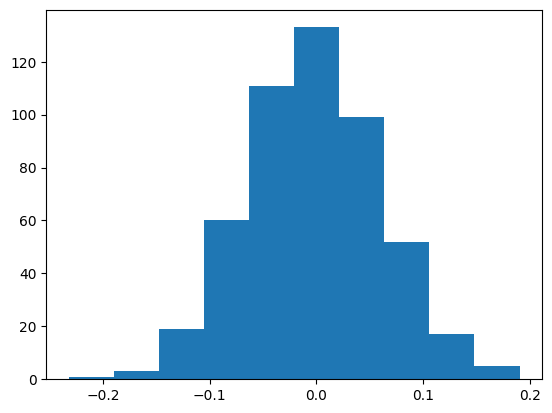

In [ ]:
plt.hist([x for x in trait_A.additive_effects.flatten().numpy() if x != 0])

(array([  5.,  24.,  60.,  93., 110., 102.,  67.,  27.,  10.,   2.]),
 array([-0.39832485,  0.19454056,  0.78740597,  1.38027143,  1.97313678,
         2.56600213,  3.1588676 ,  3.75173306,  4.34459829,  4.93746376,
         5.53032923]),
 <BarContainer object of 10 artists>)

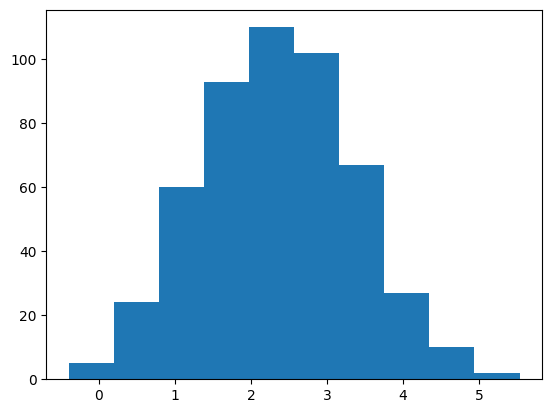

In [ ]:
plt.hist(trait_A.calculate_genetic_value(founder_pop))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()